# Notebook to make figures for conferences and manuscripts

Rainey Aberle

2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import contextily as cx
import geopandas as gpd
import pandas as pd
from skimage.measure import find_contours
import ee
import sys
from shapely.geometry import Point, LineString
import rasterio as rio
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib
import glob
import wxee as wx
import geemap
import matplotlib
import pickle
from scipy.signal import medfilt
import os

# path to snow-cover-mapping
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'

# determine whether to save output figures
save_figures = 1

# path for saving output figures
out_path = base_path+'../../write-ups/NWG_2022/'

# add path to functions
sys.path.insert(1, base_path+'functions/')
import ps_pipeline_utils as f

In [2]:
# Authenticate GEE
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

## Snow cover products comparison

In [ ]:
# -----Load Landsat fSCA
LS_fn = base_path+'../study-sites/Wolverine/imagery/Landsat/fSCA/LC08_AK_016008_20210829_20210913_02_SNOW/LC08_AK_016008_20210829_20210913_02_VIEWABLE_SNOW_UTM.TIF'
LS = rxr.open_rasterio(LS_fn)
# remove no-data values
LS = LS.where(LS != -9999)
# account for image multiplier
LS_scalar = 0.001
LS = LS * LS_scalar
crs = LS.rio.crs.to_string()

# -----Load MODIS fSCA
M_fn = base_path+'../study-sites/Wolverine/imagery/MODIS/Terra_fSCA/2021_08_15.tif'
M = rxr.open_rasterio(M_fn)
# grab snow cover band
M_fSCA = M.isel(band=0)
# remove no data values
M_fSCA = M_fSCA.where(M_fSCA != -3.2768e04)
# reproject 
M_fSCA= M_fSCA.rio.reproject(crs)

# -----Load PlanetScope image and snow
# RGB image
PS_path = base_path+'../study-sites/Wolverine/imagery/PlanetScope/adjusted-filtered/'
PS_fn = '20210815_20_adj.tif'
PS = rxr.open_rasterio(PS_path + PS_fn)
PS = PS / 1e4
# classify image
clf_fn = base_path+'/inputs-outputs/PS_classifier_all_sites.sav'
clf = pickle.load(open(clf_fn, 'rb'))
feature_cols_fn = base_path+'inputs-outputs/PS_feature_cols.pkl'
feature_cols = pickle.load(open(feature_cols_fn,'rb'))
sys.path.insert(1, base_path+'functions/')
from ps_pipeline_utils import classify_image
im_classified_fn, im = classify_image(PS_fn, PS_path, clf, feature_cols, False, None, out_path)
# load classified image
im_classified = rxr.open_rasterio(out_path + im_classified_fn) 

In [ ]:
# -----Create snow colormap
color_snow = '#4eb3d3'
color_no_snow = 'w'
# create colormap
colors = [color_no_snow, color_snow]
cmp = cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# -----Plot
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax = ax.flatten()
plt.rcParams.update({'font.size':16, 'font.sans-serif':'Arial'})
xmin, xmax, ymin, ymax = 391, 399, 6694, 6702
# MODIS
M_im = ax[0].imshow(M_fSCA.data, cmap=cmp, clim=(0,100),
                    extent=(np.min(M_fSCA.x.data)/1000, np.max(M_fSCA.x.data)/1000, 
                            np.min(M_fSCA.y.data)/1000, np.max(M_fSCA.y.data)/1000))
ax[0].set_xticks(np.linspace(392, 398, num=4))
ax[0].set_yticks(np.linspace(6694, 6702, num=5))
ax[0].set_xticklabels([])
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(ymin, ymax)
ax[0].set_ylabel('Northing [km]')
ax[0].set_title('a) MODIS f$_{SCA}$')
# LS
LS_im = ax[1].imshow(LS_fSCA, cmap=cmp, clim=(0,1),
                   extent=(np.min(LS_x)/1000, np.max(LS_x)/1000, np.min(LS_y)/1000, np.max(LS_y)/1000))
ax[1].set_xticks(np.linspace(392, 398, num=4))
ax[1].set_yticks(np.linspace(6694, 6702, num=5))
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xlim(xmin, xmax)
ax[1].set_ylim(ymin, ymax)
ax[1].set_title('b) Landsat 8 f$_{SCA}$')
# PS RGB
ax[2].imshow(np.dstack([PS.data[2], PS.data[1], PS.data[0]]),
           extent=(np.min(PS.x.data)/1000, np.max(PS.x.data)/1000, np.min(PS.y.data)/1000, np.max(PS.y.data)/1000))
ax[2].set_xticks(np.linspace(392, 398, num=4))
ax[2].set_yticks(np.linspace(6694, 6702, num=5))
ax[2].set_xlim(xmin, xmax)
ax[2].set_ylim(ymin, ymax)
ax[2].set_ylabel('Northing [km]')
ax[2].set_xlabel('Easting [km]')
ax[2].set_title('c) PlanetScope RGB')
# PS snow
im_classified = im_classified.where(im_classified!=-9999)
im_binary = xr.where(im_classified<=2, 1, 0)
PS_snow_im = ax[3].imshow(im_binary.data[0], cmap=cmp, clim=(0,1),
                   extent=(np.min(PS.x.data)/1000, np.max(PS.x.data)/1000, np.min(PS.y.data)/1000, np.max(PS.y.data)/1000))
ax[3].set_xticks(np.linspace(392, 398, num=4))
ax[3].set_yticks(np.linspace(6694, 6702, num=5))
ax[3].set_yticklabels([])
ax[3].set_xlim(xmin, xmax)
ax[3].set_ylim(ymin, ymax)
ax[3].set_xlabel('Easting [km]')
ax[3].set_title('d) PlanetScope SCA')
# colorbar
cbar_ax = fig.add_axes([0.92, 0.35, 0.02, 0.3])
fig.colorbar(M_im, cax=cbar_ax)
plt.show()

if save_figures:
    fig.savefig(out_path+'comparing_SCA_products.png', dpi=300, facecolor='white', edgecolor='none')
    print('figure saved to file')

## Study sites

32606
32606
32608
32610
32612


/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_9960/3541919743.py:64: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


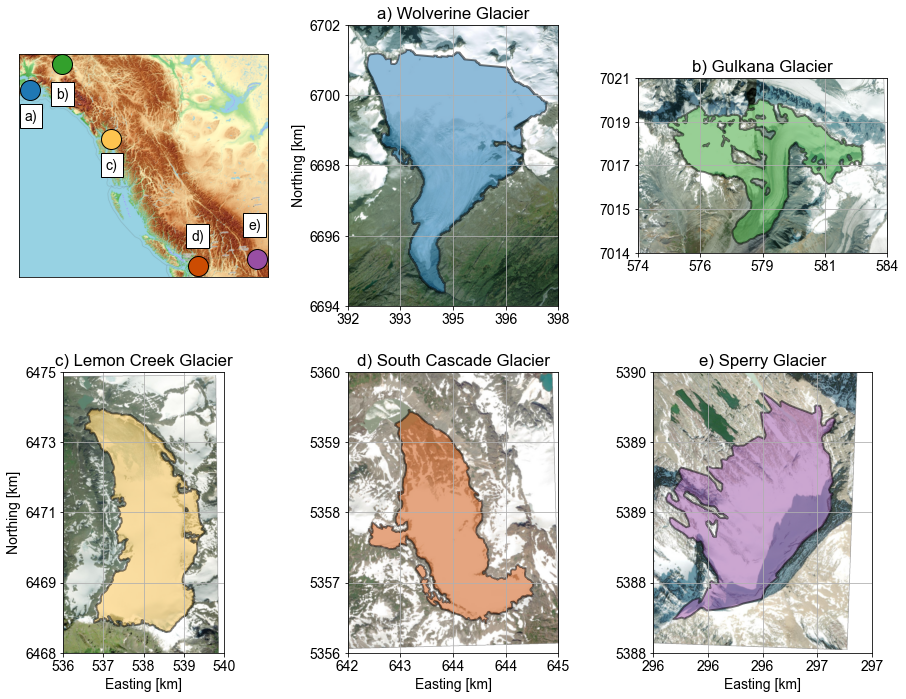

In [59]:
site_names = ['Wolverine', 'Gulkana', 'LemonCreek', 'SCascade', 'Sperry']
site_names_display = ['Wolverine', 'Gulkana', 'Lemon Creek', 'South Cascade', 'Sperry']
site_colors = ['#1f78b4', '#33a02c', '#fec44f', '#cc4c02', '#984ea3']
text_labels = ['a) ', 'b) ', 'c) ', 'd) ', 'e) ']

# -----Set up figure
fig, ax = plt.subplots(2, 3, figsize=(16, 12), layout='constrained')
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})
ax = ax.flatten()

# A: study sites map
epsg = 32610
for site_name, site_color, site_name_display, i in list(zip(site_names, site_colors, site_names_display, np.arange(0,len(site_names)))):
    AOI_fn = base_path + '../../GIS_data/RGI_outlines/' + site_name + '_RGI.shp'
    AOI = gpd.read_file(AOI_fn)
    AOI = AOI.to_crs(epsg)
    ax[0].plot(AOI.geometry[0].centroid.xy[0][0], AOI.geometry[0].centroid.xy[1][0], 
            'o', markerfacecolor=site_color, markeredgecolor='k', markersize=20)
cx.add_basemap(ax[0], crs=AOI.crs.to_string(), source=cx.providers.OpenTopoMap, attribution=False)
ax[0].set_xticks([])
ax[0].set_yticks([])
# add text label locators
ax[0].text(-950000, 6700000, 'a)', bbox=dict(facecolor='white', edgecolor='black', pad=5))
ax[0].text(-660000, 6900000, 'b)', bbox=dict(facecolor='white', edgecolor='black', pad=5))
ax[0].text(-205000, 6250000, 'c)', bbox=dict(facecolor='white', edgecolor='black', pad=5))
ax[0].text(580000, 5600000, 'd)', bbox=dict(facecolor='white', edgecolor='black', pad=5))
ax[0].text(1100000, 5700000, 'e)', bbox=dict(facecolor='white', edgecolor='black', pad=5))

# B-F: individual glaciers
i=0
for site_name, site_color, site_name_display, text_label in list(zip(site_names, site_colors, site_names_display, text_labels)):
    AOI_fn = base_path + '../../GIS_data/RGI_outlines/' + site_name + '_RGI.shp'
    AOI = gpd.read_file(AOI_fn)
    # solve for optimal UTM zone
    AOI_centroid = [AOI.geometry[0].centroid.xy[0][0],
                    AOI.geometry[0].centroid.xy[1][0]]
    epsg_UTM = f.convert_wgs_to_utm(AOI_centroid[0], AOI_centroid[1])
    print(epsg_UTM)
    # reproject AOI
    AOI_UTM = AOI.to_crs(epsg_UTM)
    # plot
    AOI_UTM.plot(ax=ax[i+1], edgecolor='k', facecolor=site_color, alpha=0.5, linewidth=2)
    # add basemap
    cx.add_basemap(ax[i+1], crs=AOI_UTM.crs.to_string(), source=cx.providers.Esri.WorldImagery, attribution=False)
    ax[i+1].grid()
    # change x and y tick labels to km
    xmin = np.min(ax[i+1].get_xticks())
    xmax = np.max(ax[i+1].get_xticks())
    ymin = np.min(ax[i+1].get_yticks())
    ymax = np.max(ax[i+1].get_yticks())
    ax[i+1].set_xticks(np.linspace(xmin, xmax, num=5))
    ax[i+1].set_xticklabels([str(int(x/1e3)) for x in ax[i+1].get_xticks()])
    ax[i+1].set_yticks(np.linspace(ymin, ymax, num=5))
    ax[i+1].set_yticklabels([str(int(y/1e3)) for y in ax[i+1].get_yticks()])
    ax[i+1].set_title(text_label + site_name_display + ' Glacier')
    # add axes labels
    if (i==1) or (i==3):
        ax[i].set_ylabel('Northing [km]')
    if i > 1:
        ax[i+1].set_xlabel('Easting [km]')
    # increase loop counter
    i+=1

fig.tight_layout()
plt.show()

if save_figures:
    fig.savefig(out_path+'study_sites.png', dpi=300, facecolor='white', edgecolor='none')
    print('figure saved to file')

## Methods workflow

In [ ]:
# -----Image settings
# image date
im_date = '20190728'
# image band scalar multiplier
im_scalar = 1e4
# site name
site_name = 'SCascade'
# RGI outline
AOI_fn = base_path + '../../GIS_data/RGI_outlines/SCascade_RGI.shp'
AOI = gpd.read_file(AOI_fn)
# query GEE for DEM
DEM, AOI_UTM = f.query_GEE_for_DEM(AOI)
# define colors for classified image
color_snow = '#4eb3d3'
color_ice = '#084081'
color_rock = '#fdbb84'
color_water = '#bdbdbd'
# create colormap
colors = [color_snow, color_snow, color_ice, color_rock, color_water]
cmp = ListedColormap(colors)

# -----1. Raw image
im_path = base_path + '../study-sites/SCascade/imagery/PlanetScope/mosaics/'
im_fn = glob.glob(im_path + im_date + '*.tif')[0]
im = rxr.open_rasterio(im_fn)
im = im / im_scalar
xmin, xmax, ymin, ymax = np.min(im.x.data), np.max(im.x.data), np.min(im.y.data), np.max(im.y.data)
# plot
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.imshow(np.dstack([im.data[2], im.data[1], im.data[0]]), 
           extent=(xmin, xmax, ymin, ymax))
AOI_UTM.plot(ax=ax1, facecolor='none', edgecolor=site_colors[3], linewidth=3)
ax1.set_xticks([])
ax1.set_yticks([])

# -----2. Adjusted image
im_adj_path = base_path + '../study-sites/SCascade/imagery/PlanetScope/adjusted-filtered/'
im_adj_fn = glob.glob(im_adj_path+im_date+'*_adj.tif')[0]
im_adj = rxr.open_rasterio(im_adj_fn)
im_adj = im_adj / im_scalar
# plot
fig2, ax2 = plt.subplots(figsize=(8,8))
ax2.imshow(np.dstack([im_adj.data[2], im_adj.data[1], im_adj.data[0]]), 
           extent=(xmin, xmax, ymin, ymax))
AOI_UTM.plot(ax=ax2, facecolor='none', edgecolor=site_colors[3], linewidth=3)
ax2.set_xticks([])
ax2.set_yticks([])

# -----3. Classified image
im_classified_path = base_path + '../study-sites/SCascade/imagery/PlanetScope/classified/'
im_classified_fn = glob.glob(im_classified_path+im_date+'*_classified.tif')[0]
im_classified = rxr.open_rasterio(im_classified_fn)
im_classified = im_classified.where(im_classified!=-9999) # remove no data values
# Adjust classified image
# mask the DEM using the AOI
mask = rio.features.geometry_mask(AOI_UTM.geometry,
                                  out_shape=(len(DEM.y), len(DEM.x)),
                                  transform=DEM.transform,
                                  invert=True)
# convert mask to xarray DataArray
mask = xr.DataArray(mask , dims=("y", "x"))
# mask DEM values outside the AOI
DEM_AOI = DEM.where(mask == True)
# interpolate DEM to the image coordinates
band, x, y = im_classified.indexes.values() # grab indices of image
DEM_AOI_interp = DEM_AOI.interp(x=x, y=y, method="nearest") # interpolate DEM to image coordinates
# determine snow covered elevations
DEM_AOI_interp_snow = DEM_AOI_interp.where(im_classified<=2) # mask pixels not classified as snow
snow_est_elev = DEM_AOI_interp_snow.elevation.data.flatten() # create array of snow-covered pixel elevations
# determine bins to use in histograms
elev_min = np.fix(np.nanmin(DEM_AOI_interp.elevation.data.flatten())/10)*10
elev_max = np.round(np.nanmax(DEM_AOI_interp.elevation.data.flatten())/10)*10
bin_edges = np.linspace(elev_min, elev_max, num=int((elev_max-elev_min)/10 + 1))
bin_centers = (bin_edges[1:] + bin_edges[0:-1]) / 2
# calculate elevation histograms
H_DEM = np.histogram(DEM_AOI_interp.elevation.data.flatten(), bins=bin_edges)[0]
H_snow_est_elev = np.histogram(snow_est_elev, bins=bin_edges)[0]
H_snow_est_elev_norm = H_snow_est_elev / H_DEM
# determine elevation with > 75% snow coverage
elev_75_snow = bin_centers[np.where(H_snow_est_elev_norm > 0.75)[0][0]]
# set all pixels above the elev_75_snow to snow (1)
im_classified_adj = xr.where(DEM_AOI_interp.elevation > elev_75_snow, 1, im_classified) # set all values above elev_75_snow to snow (1)
im_classified_adj = im_classified_adj.squeeze(drop=True) # drop unecessary dimensions
# define color scheme
# plot
fig3, ax3 = plt.subplots(figsize=(8,8))
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})
ax3.imshow(im_classified_adj.data, cmap=cmp, vmin=1, vmax=5,
           extent=(xmin, xmax, ymin, ymax))
AOI_UTM.plot(ax=ax3, facecolor='none', edgecolor=site_colors[3], linewidth=3)
# plot dummy points for legend
ax3.scatter(0, 0, color=color_snow, s=50, label='snow')
ax3.scatter(0, 0, color=color_ice, s=50, label='ice')
ax3.scatter(0, 0, color=color_rock, s=50, label='bare ground')
ax3.scatter(0, 0, color=color_water, s=50, label='water')
ax3.set_xlim(xmin, xmax)
ax3.set_ylim(ymin, ymax)
ax3.legend(loc='right')
ax3.set_xticks([])
ax3.set_yticks([])

# -----4. Image contours
# create binary snow matrix
im_binary = xr.where(im_classified_adj <=2, 1, 0).data
# Find contours at a constant value of 0.5 (between 0 and 1)
contours = find_contours(im_binary, 0.5)
# convert contour points to image coordinates
contours_coords = []
for contour in contours: 
    ix = np.round(contour[:,1]).astype(int)
    iy = np.round(contour[:,0]).astype(int)
    coords = (im_adj.isel(x=ix, y=iy).x.data, # image x coordinates
              im_adj.isel(x=ix, y=iy).y.data) # image y coordinates
    # zip points together
    xy = list(zip([x for x in coords[0]], 
                  [y for y in coords[1]]))
    contours_coords = contours_coords + [xy]
# plot
fig4, ax4 = plt.subplots(figsize=(8,8))
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})
binary_plt = ax4.imshow(im_binary, cmap='Greys')
for i, contour in list(zip(np.arange(0,len(contours)), contours)):
    if i==0:
        plt.plot(contour[:,1], contour[:,0], '-m', label='contours', linewidth=2)
    else:
        plt.plot(contour[:,1], contour[:,0], '-m', label='_nolegend', linewidth=2)
# plot dummy points for legend
ax4.scatter(np.array([-10, -9]),np.array([-10, -9]), edgecolor='k', facecolor='k', s=100, label='snow')
ax4.scatter(np.array([-10, -9]),np.array([-10, -9]), edgecolor='k', facecolor='w', s=100, label='no snow')
ax4.set_xlim(0,len(im.x.data))
ax4.set_ylim(len(im.y.data), 0)
ax4.legend(loc='right')
ax4.set_xticks([])
ax4.set_yticks([])

# -----5. Filtered contours / snow line
# extract snow lines (sl) from contours
sl_est = [] # initialize list of snow lines
# loop through contours
for c in contours_coords: 
    # create array of points
    c_points =  [Point(x,y) for x,y in c]
    # loop through points 
    line_points = [] # initialize list of points to use in snow line
    for point in c_points:
        # calculate distance from the point to the AOI boundary
        distance = AOI_UTM.boundary[0].distance(point)
        # only include points 200 m from the AOI boundary
        if distance >= 100:
            line_points = line_points + [point]
    if line_points: # if list of line points is not empty
        if len(line_points) > 1: # must have at least two points to create a LineString
            line = LineString([(p.xy[0][0], p.xy[1][0]) for p in line_points])
            sl_est = sl_est + [line]
# filter lines by length
sl_est_filt = []
for line in sl_est:
    if line.length > 1000:
        sl_est_filt = sl_est_filt + [line]  
# compile all line coordinates into arrays of x- and y-coordinates 
xpts, ypts = [], []
for line in sl_est_filt:
    xpts = xpts + [x for x in line.coords.xy[0]]
    ypts = ypts + [y for y in line.coords.xy[1]]  
xpts, ypts = np.array(xpts).flatten(), np.array(ypts).flatten()
# plot 
fig5, ax5 = plt.subplots(figsize=(8,8))
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})
ax5.imshow(im_binary, cmap='Greys',
           extent=(xmin, xmax, ymin, ymax))
ax5.plot([x for x in xpts], 
         [y for y in ypts], 
         '-', color='m', label='estimated snowline', linewidth=3) 
# plot dummy points for legend
ax5.scatter(np.array([-10, -9]),np.array([-10, -9]), edgecolor='k', facecolor='k', s=100, label='snow')
ax5.scatter(np.array([-10, -9]),np.array([-10, -9]), edgecolor='k', facecolor='w', s=100, label='no snow')
ax5.set_xlim(xmin,xmax)
ax5.set_ylim(ymin, ymax)
ax5.legend(loc='right')
ax5.set_xticks([])
ax5.set_yticks([])

# -----6. Snow line elevations
# compile all line coordinates into arrays of x- and y-coordinates 
xpts, ypts = [], []
for line in sl_est:
    xpts = xpts + [x for x in line.coords.xy[0]]
    ypts = ypts + [y for y in line.coords.xy[1]]  
xpts, ypts = np.array(xpts).flatten(), np.array(ypts).flatten()
# interpolate elevation at snow line points
sl_est_elev = [DEM.sel(x=x, y=y, method='nearest').elevation.data[0] 
               for x, y in list(zip(xpts, ypts))]
# calculate median snow line elevation
sl_est_elev_median = np.nanmedian(sl_est_elev)
# calculate histogram
H_snow_line_elev = np.histogram(sl_est_elev, bins=bin_edges)[0]
# plot
fig6, ax6 = plt.subplots(figsize=(12,6))
plt.rcParams.update({'font.size':20, 'font.sans-serif':'Arial'})
ax6.bar(bin_centers, H_snow_est_elev, width=(bin_centers[1]-bin_centers[0]), 
        color=color_snow, align='center', label='snow-covered')
ax6.bar(bin_centers, H_snow_line_elev, width=(bin_centers[1]-bin_centers[0]), 
        color='m', align='center', label='snow line')
ax6.plot((sl_est_elev_median, sl_est_elev_median), (0, 9.5e3), '--m', linewidth=3, label='median snow line elevation')
ax6.set_ylim(0,9.5e3)
ax6.grid()
ax6.legend(loc='upper left')
ax6.set_xlabel('Elevation [m]')
ax6.set_ylabel('Pixel count')
plt.show()

if save_figures:
    fig1.savefig(out_path+'processing_workflow_1.png', dpi=300, facecolor='white', edgecolor='none')
    fig2.savefig(out_path+'processing_workflow_2.png', dpi=300, facecolor='white', edgecolor='none')
    fig3.savefig(out_path+'processing_workflow_3.png', dpi=300, facecolor='white', edgecolor='none')
    fig4.savefig(out_path+'processing_workflow_4.png', dpi=300, facecolor='white', edgecolor='none')
    fig5.savefig(out_path+'processing_workflow_5.png', dpi=300, facecolor='white', edgecolor='none')
    fig6.savefig(out_path+'processing_workflow_6.png', dpi=300, facecolor='white', edgecolor='none')
    print('figures saved to file')

## Median snow line elevations

In [ ]:
site_names = ['Wolverine', 'Gulkana', 'LemonCreek', 'SCascade', 'Sperry']
site_names_display = ['Wolverine', 'Gulkana', 'Lemon Creek', 'South Cascade', 'Sperry']
site_colors = ['#1f78b4', '#33a02c', '#fec44f', '#cc4c02', '#984ea3']
text_labels = ['a)', 'b)', 'c)', 'd)', 'e)']

# set up figure
fig, ax = plt.subplots(3, 2, figsize=(16, 8))
ax = ax.flatten()
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})
# minor ticks every month.
fmt_month = matplotlib.dates.MonthLocator(bymonth=(5, 11))
# minor ticks every year.
fmt_year = matplotlib.dates.YearLocator()

# -----Loop through sites
for site_name, site_name_display, site_color, text_label, i in list(zip(site_names, site_names_display, site_colors, text_labels, np.arange(0,len(site_names)))):
    
    # -----Observed snow lines
    # define path to digitized snow lines
    sl_obs_path = base_path + '../snowline-package/' + site_name + '/snowlines/'
    sl_obs_fns = glob.glob(sl_obs_path + '*.shp')
    # load AOI as gpd.GeoDataFrame
    AOI_fn = base_path + '../../GIS_data/RGI_outlines/' + site_name + '_RGI.shp'
    AOI = gpd.read_file(AOI_fn)
    # query GEE for DEM
    DEM, AOI_UTM = f.query_GEE_for_DEM(AOI)
    # loop through observed snow lines
    for sl_obs_fn in sl_obs_fns:
        # load observed snow line
        sl_obs = gpd.read_file(sl_obs_fn)
        # extract date from filename
        date = sl_obs_fn.split('/'+site_name+'_')[1][0:8]
        datetime = np.datetime64(date[0:4] + '-' + date[4:6] + '-' + date[6:8]
                                 + 'T00:00:00')
        # reproject snow line to UTM
        sl_obs_UTM = sl_obs.to_crs(str(AOI_UTM.crs.to_epsg()))
        # interpolate elevation at snow line points
        if len(sl_obs_UTM) > 1:
            sl_obs_elev = np.array([DEM.sel(time=DEM.time.data[0], x=x, y=y, method='nearest').elevation.data 
                                for x, y in list(zip(sl_obs_UTM.geometry[1].xy[0], 
                                                     sl_obs_UTM.geometry[1].xy[1]))])
        else:
            sl_obs_elev = np.array([DEM.sel(time=DEM.time.data[0], x=x, y=y, method='nearest').elevation.data 
                                for x, y in list(zip(sl_obs_UTM.geometry[0].xy[0], 
                                                     sl_obs_UTM.geometry[0].xy[1]))])
        # calculate median snow line elevation
        sl_obs_elev_median = np.nanmedian(sl_obs_elev)
        # plot
        ax[i].plot(datetime, sl_obs_elev_median, 'xk', markersize=8, linewidth=3, label='_nolegend_')
    
    # -----Estimated snow line
    # load file
    sl_est_path = base_path + '../study-sites/' + site_name + '/figures/' + site_name + '_sl_elevs.pkl'
    sl_est = pd.read_pickle(sl_est_path)
    # extract maximum annual sl_est
    sl_est['year'] = [x.year for x in sl_est['datetime']]
    years = np.unique(sl_est['year'])
    for year in years:
        sl_est_max_annual = sl_est['snowlines_elevs_median'][sl_est['year']==year].max()
        sl_est_max_annual_datetime = np.max(sl_est['datetime'][(sl_est['year']==year) 
                                                               & (sl_est['snowlines_elevs_median']==sl_est_max_annual)])
        ax[5].scatter(sl_est_max_annual_datetime, sl_est_max_annual,
                      edgecolors=site_color, facecolors='none', linewidth=2, 
                      s=40, label='_nolegend_')
    # calculate moving mean of snowline elevations
    # def moving_average(x, w):
    #     return np.convolve(x, np.ones(w), 'valid') / w
    # for year in years:
    #     sl_est_subset = sl_est[sl_est['year']==year]
    #     movmean = np.concatenate((np.array([np.nan]),
    #                       moving_average(sl_est_subset['snowlines_elevs_median'],3), 
    #                       np.array([np.nan])))
    #     ax[i].plot(sl_est_subset['datetime'], movmean, '-', color=site_color)
    # plot
    # dummy points for legend
    if i==0:
        ax[i].scatter(np.datetime64('1970-01-01'), 0, edgecolors='k', 
                      facecolors='k', s=15, label='estimated')
        ax[i].plot(datetime, sl_obs_elev_median, 'xk', markersize=8, 
                   linewidth=3, label='observed')

    ax[i].scatter(sl_est['datetime'], sl_est['snowlines_elevs_median'], 
               edgecolors=site_color, facecolors=site_color, s=15, label=site_name_display)
    ax[i].grid()
    # axis limits
    xmin, xmax = np.datetime64('2016-05-01T00:00:00'), np.datetime64('2021-11-01T00:00:00')
    ymin, ymax = np.min(sl_est['snowlines_elevs_median'])-50, np.max(sl_est['snowlines_elevs_median'])+200
    ax[i].set_xlim(xmin, xmax)
    ax[i].set_ylim(ymin, ymax)
    # x-labels
    ax[i].xaxis.set_minor_formatter(matplotlib.dates.DateFormatter('%b'))
    ax[i].xaxis.set_major_locator(fmt_month)
    ax[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
    # create a second x-axis beneath the first x-axis to show the year in YYYY format
    sec_xaxis = ax[i].secondary_xaxis(-0.1)
    sec_xaxis.xaxis.set_major_locator(fmt_year)
    sec_xaxis.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    # Hide the second x-axis spines and ticks
    sec_xaxis.spines['bottom'].set_visible(False)
    sec_xaxis.tick_params(axis='x', length=0, pad=15)
    if i<4:
        ax[i].set_xticklabels([])
        sec_xaxis.set_xticklabels([])
    # y-label
    if (i==0) or (i==2) or (i==4):
        ax[i].set_ylabel('Elevation [m]')
    # text label
    ax[i].text((xmax-xmin)*0.015 + xmin, (ymax-ymin)*0.87 + ymin, 
               text_label + ' ' + site_name_display, 
               bbox=dict(facecolor='white', edgecolor='black', pad=5))
        
# -----Plot maximum sl elevations
ax[5].xaxis.set_minor_formatter(matplotlib.dates.DateFormatter('%b'))
ax[5].xaxis.set_major_locator(fmt_month)
ax[5].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
# create a second x-axis beneath the first x-axis to show the year in YYYY format
sec_xaxis = ax[5].secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(fmt_year)
sec_xaxis.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
# Hide the second x-axis spines and ticks
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0, pad=10)
ax[5].set_xlim(np.datetime64('2016-05-01T00:00:00'), np.datetime64('2021-11-01T00:00:00'))
# text label
ymin, ymax = 950, 2950
ax[5].set_ylim(ymin, ymax)
ax[5].text((xmax-xmin)*0.015 + xmin, (ymax-ymin)*0.87 + ymin, 
           'f) All sites annual maximum', 
           bbox=dict(facecolor='white', edgecolor='black', pad=5))
ax[5].grid()
plt.show()

# -----Save figure
if save_figures:
    fig_fn = 'all_sites_median_sl_elevs.png'
    fig.savefig(out_path + fig_fn, facecolor='w', dpi=300)
    print('figure saved to file')

In [ ]:
# Try only two subplots

site_names = ['Wolverine', 'Gulkana', 'LemonCreek', 'SCascade', 'Sperry']
site_names_display = ['Wolverine', 'Gulkana', 'Lemon Creek', 'South Cascade', 'Sperry']
site_colors = ['#1f78b4', '#33a02c', '#fec44f', '#cc4c02', '#984ea3']
text_labels = ['a) ', 'b) ', 'c) ', 'd) ', 'e) ']

# set up figure
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
ax = ax.flatten()
ax[0].grid()
ax[1].grid()
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})

# -----Loop through sites
for site_name, site_name_display, site_color, text_label, i in list(zip(site_names, site_names_display, site_colors, text_labels, np.arange(0,len(site_names)))):
    
    # -----Estimated snow line
    # load file
    sl_est_path = base_path + '../study-sites/' + site_name + '/figures/' + site_name + '_sl_elevs.pkl'
    sl_est = pd.read_pickle(sl_est_path)
    # extract maximum annual sl_est
    sl_est.index = sl_est['datetime']
    sl_est_max_annual = sl_est['snowlines_elevs_median'].groupby(pd.Grouper(freq='Y')).max()
    ax[1].plot(sl_est_max_annual, '.', color=site_color, markersize=15)
    # plot
    ax[0].plot(sl_est['datetime'], sl_est['snowlines_elevs_median'], '.-', 
               color=site_color, markersize=5)
    # moving mean
    # sl_est['year'] = [x.year for x in sl_est['datetime']]
    # years = np.unique(sl_est['year'])
    # def moving_average(x, w):
    #     return np.convolve(x, np.ones(w), 'valid') / w
    # for year in years:
    #     sl_est_subset = sl_est[sl_est['year']==year]
    #     # movmean = np.concatenate((np.array([np.nan]),
    #     #                   moving_average(sl_est_subset['snowlines_elevs_median'],3), 
    #     #                   np.array([np.nan])))
    #     # ax[0].plot(sl_est_subset['datetime'], movmean, '-', color=site_color)
    #     ax[0].plot(sl_est_subset['datetime'], medfilt(sl_est_subset['snowlines_elevs_median'],3),
    #                '-', color=site_color)
        
    
    # -----Observed snow lines
    # define path to digitized snow lines
    sl_obs_path = base_path + '../snowline-package/' + site_name + '/snowlines/'
    sl_obs_fns = glob.glob(sl_obs_path + '*.shp')
    # load AOI as gpd.GeoDataFrame
    AOI_fn = base_path + '../../GIS_data/RGI_outlines/' + site_name + '_RGI.shp'
    AOI = gpd.read_file(AOI_fn)
    # query GEE for DEM
    DEM, AOI_UTM = f.query_GEE_for_DEM(AOI)
    # loop through observed snow lines
    for sl_obs_fn in sl_obs_fns:
        # load observed snow line
        sl_obs = gpd.read_file(sl_obs_fn)
        # extract date from filename
        date = sl_obs_fn.split('/'+site_name+'_')[1][0:8]
        datetime = np.datetime64(date[0:4] + '-' + date[4:6] + '-' + date[6:8]
                                 + 'T00:00:00')
        # reproject snow line to UTM
        sl_obs_UTM = sl_obs.to_crs(str(AOI_UTM.crs.to_epsg()))
        # interpolate elevation at snow line points
        if len(sl_obs_UTM) > 1:
            sl_obs_elev = np.array([DEM.sel(time=DEM.time.data[0], x=x, y=y, method='nearest').elevation.data 
                                for x, y in list(zip(sl_obs_UTM.geometry[1].xy[0], 
                                                     sl_obs_UTM.geometry[1].xy[1]))])
        else:
            sl_obs_elev = np.array([DEM.sel(time=DEM.time.data[0], x=x, y=y, method='nearest').elevation.data 
                                for x, y in list(zip(sl_obs_UTM.geometry[0].xy[0], 
                                                     sl_obs_UTM.geometry[0].xy[1]))])
        # calculate median snow line elevation
        sl_obs_elev_median = np.nanmedian(sl_obs_elev)
        # plot
        ax[0].plot(datetime, sl_obs_elev_median, 'x', markersize=8, color=site_color)
        
ax[0].set_xlim(np.datetime64('2016-05-01T00:00:00'), np.datetime64('2021-11-01T00:00:00'))

plt.show()
    

## Issue images

In [ ]:
# -----Multiple snow line picks
site_name = 'Gulkana'
im_date = '20170623'
# load adjusted image
im_adj_path = base_path + '../study-sites/' + site_name + '/imagery/PlanetScope/adjusted-filtered/'
os.chdir(im_adj_path)
im_adj_fn = glob.glob(im_date+'*.tif')[0]
im_adj = rxr.open_rasterio(im_adj_path + im_adj_fn)
im_adj = im_adj / 10000
# load classified image
im_classified_path = base_path + '../study-sites/' + site_name + '/imagery/PlanetScope/classified/'
os.chdir(im_classified_path)
im_classified_fn = glob.glob(im_date+'*.tif')[0]
im_classified = rxr.open_rasterio(im_classified_path + im_classified_fn)
im_classified = im_classified.where(im_classified!=-9999)
# load snow line coordinates
sl_est_path = base_path + '../study-sites/' + site_name + '/figures/' + site_name + '_sl_elevs.pkl'
sl_est = pd.read_pickle(sl_est_path)
sl_est = sl_est.reset_index(drop=True)
sl_est_sub = sl_est[sl_est['study_site']=='Gulkana']
sl_est_coords = sl_est_sub.iloc[12]['snowlines_coords']
# load AOI as gpd.GeoDataFrame
AOI_fn = base_path + '../../GIS_data/RGI_outlines/' + site_name + '_RGI.shp'
AOI = gpd.read_file(AOI_fn)

# plot
fig, ax = plt.subplots(2, 2, figsize=(10,10), gridspec_kw={'width_ratios': [2, 1]})
ax = ax.flatten()
plt.rcParams.update({'font.size': 16, 'font.sans-serif': 'Arial'})
# define x and y limits
xmin, xmax = np.min(im_classified.x.data)/1e3, np.max(im_classified.x.data)/1e3
ymin, ymax = np.min(im_classified.y.data)/1e3, np.max(im_classified.y.data)/1e3
# define colors for plotting
color_snow = '#4eb3d3'
color_ice = '#084081'
color_rock = '#fdbb84'
color_water = '#bdbdbd'
color_contour = '#f768a1'
# create colormap
colors = [color_snow, color_snow, color_ice, color_rock, color_water]
cmp = matplotlib.colors.ListedColormap(colors)
# RGB image
ax[0].imshow(np.dstack([im_adj.data[2], im_adj.data[1], im_adj.data[0]]),
           extent=(xmin, xmax, ymin, ymax))
ax[0].set_ylabel("Northing [km]")
# classified image
ax[2].imshow(im_classified.data[0], cmap=cmp, vmin=1, vmax=5,
             extent=(xmin, xmax, ymin, ymax))
# plot estimated snow line coordinates
i=0
for line in sl_est_coords:
    if i==0:
        ax[0].plot([x/1e3 for x in line.coords.xy[0]],
                   [x/1e3 for x in line.coords.xy[1]],
                   '.-m', label='sl$_{estimated}$', markersize=3)
    else:
        ax[0].plot([x/1e3 for x in line.coords.xy[0]],
                   [x/1e3 for x in line.coords.xy[1]],
                   '.-m', label='_nolegend_', markersize=3)
    ax[2].plot([x/1e3 for x in line.coords.xy[0]],
               [x/1e3 for x in line.coords.xy[1]],
               '.-m', label='_nolegend_', markersize=3)
    i+=1
# plot dummy points for legend
ax[2].scatter(0, 0, color=color_snow, s=50, label='snow')
ax[2].scatter(0, 0, color=color_ice, s=50, label='ice')
ax[2].scatter(0, 0, color=color_rock, s=50, label='rock')
ax[2].scatter(0, 0, color=color_water, s=50, label='water')
ax[2].set_xlabel('Easting [km]')
ax[2].set_ylabel('Northing [km]')
# AOI
ax[0].plot([x/1e3 for x in AOI_UTM.exterior[0].coords.xy[0]], 
           [y/1e3 for y in AOI_UTM.exterior[0].coords.xy[1]], '-k', linewidth=1, label='AOI')
ax[2].plot([x/1e3 for x in AOI_UTM.exterior[0].coords.xy[0]], 
           [y/1e3 for y in AOI_UTM.exterior[0].coords.xy[1]], '-k', linewidth=1, label='_nolegend_')
ax[0].legend(loc='best')
ax[2].legend(loc='best')
# reset x and y limits
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(ymin, ymax)
ax[2].set_xlim(xmin, xmax)
ax[2].set_ylim(ymin, ymax)

# -----no snow Lemon Creek
site_name = 'LemonCreek'
im_date = '20180820'
# load raw image
im_path = base_path + '../study-sites/' + site_name + '/imagery/PlanetScope/mosaics/'
os.chdir(im_path)
im_fn = glob.glob(im_date+'*.tif')[0]
im = rxr.open_rasterio(im_path + im_fn)
im = im / 10000
# load adjusted image
im_adj_path = base_path + '../study-sites/' + site_name + '/imagery/PlanetScope/adjusted-filtered/'
os.chdir(im_adj_path)
im_adj_fn = glob.glob(im_date+'*.tif')[0]
im_adj = rxr.open_rasterio(im_adj_path + im_adj_fn)
im_adj = im_adj / 10000
# plot
# raw image
xmin, xmax = np.min(im.x.data)/1e3, np.max(im.x.data)/1e3
ymin, ymax = np.min(im.y.data)/1e3, np.max(im.y.data)/1e3
ax[1].imshow(np.dstack([im.data[2], im.data[1], im.data[0]]),
             extent=(xmin, xmax, ymin, ymax))
# adjusted image
ax[3].imshow(np.dstack([im_adj.data[2], im_adj.data[1], im_adj.data[0]]),
             extent=(xmin, xmax, ymin, ymax))
ax[3].set_xlabel("Easting [km]")

# add text labels
xmin, xmax = ax[0].get_xlim()
ymin, ymax = ax[0].get_ylim()
ax[0].text((xmax-xmin)*0.015 + xmin, (ymax-ymin)*0.94 + ymin, 
           'a)', bbox=dict(facecolor='white', edgecolor='black', pad=5))
ax[0].set_title('Multiple snow line picks')
xmin, xmax = ax[1].get_xlim()
ymin, ymax = ax[1].get_ylim()
ax[1].text((xmax-xmin)*0.03 + xmin, (ymax-ymin)*0.94 + ymin, 
           'b)', bbox=dict(facecolor='white', edgecolor='black', pad=5))
ax[1].set_title('No snow cover')
xmin, xmax = ax[2].get_xlim()
ymin, ymax = ax[2].get_ylim()
ax[2].text((xmax-xmin)*0.015 + xmin, (ymax-ymin)*0.94 + ymin, 
           'c)', bbox=dict(facecolor='white', edgecolor='black', pad=5))
xmin, xmax = ax[3].get_xlim()
ymin, ymax = ax[3].get_ylim()
ax[3].text((xmax-xmin)*0.03 + xmin, (ymax-ymin)*0.94 + ymin, 
           'd)', bbox=dict(facecolor='white', edgecolor='black', pad=5))

fig.tight_layout()
plt.show()

# -----Save figure
if save_figures:
    fig_fn = 'issue_images.png'
    fig.savefig(out_path + fig_fn, facecolor='w', dpi=300)
    print('figure saved to file')
    